In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from metronome import p_func, interval_calc

pygame 2.6.0 (SDL 2.28.4, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('hls', 10, desat = 0.8)
#colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)

#sns.palplot(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 150

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [3]:
def slope_fork(x_j):
    if x_j >= 0.5:
        return 1
    else:
        return -0.59
    
def update_x(x_j, eps, N_tot):
    x_up = x_j + (slope_fork(x_j) * eps) / N_tot
    if x_up < 1:
        return x_up
    else:
        return 1
    
def met_update_x(x_j, met_eps, N_tot):
    x_up = x_j + (slope_fork(x_j) * met_eps) / N_tot
    if x_up < 1:
        return x_up
    else:
        return 1

def clap(x, w, t, t_clap, sig):
    x = 0
    w = np.random.normal(0, sig) + 1 / (t - t_clap)
    t_clap = t
    return x, w, t_clap

def p_func(n_beat, threshold_l = 16, threshold_h = 32):
    if n_beat <= threshold_l:
        p = 1
    elif n_beat > threshold_l and n_beat <= threshold_h:
        p = 1/2 * (1 + np.cos(np.pi * (n_beat - threshold_l) / (threshold_h - threshold_l + 1)))
    else:
        p = 0 
    return p

def interval_calc(bpm_i, bpm_f, p):
    c_start = 60 / bpm_i
    c_end = 60 / bpm_f
    c_i = p * c_start + (1 - p) * c_end
    return c_i





In [4]:
def sim_with_metronome(x_init, w_init, t_clap_init, dt, tmax, freq_met=1.0, sig=0.1, eps=0.1, met_eps = 0.1):

    t = 0.1
    x = x_init.copy()
    w = w_init.copy()
    t_clap = t_clap_init.copy()
    x0_save = []
    
    N = len(w)
    w_save = [[] for i in range(N)]
    t_save = [[] for i in range(N)]
    avg_save = []
    
    x_met = 0  #metronome starts at phase 0

    for entry in range(len(w_save)):
        w_save[entry].append(w[entry])
        t_save[entry].append(t)

    while t < tmax:
        
        # metronome
        x_met += dt * freq_met
        if x_met >= 1:
            x_met = 0  # reset metronome

            # affect clappers
            for i in range(len(x)):
                x[i] = met_update_x(x[i], met_eps, N)

        x = x + w * dt

        index = np.where(x >= 1)[0] 
        
        if len(index) > 0: 
            for i in index:
                x[i] = 0  
                w[i] = np.random.normal(0, sig) + 1 / (t - t_clap[i]) 
                t_clap[i] = t
                
                w_save[i].append(w[i])
                t_save[i].append(t_clap[i])

                for j in range(len(x)):
                    if j != i:
                        x[j] = update_x(x[j], eps, N) 
                    else:
                        continue             

        t += dt
        x0_save.append(x[0])

        if int(t % (dt * 10)) == 0: 
            avg_save.append(np.mean(w))
            
    return w_save, t_save, x0_save, avg_save

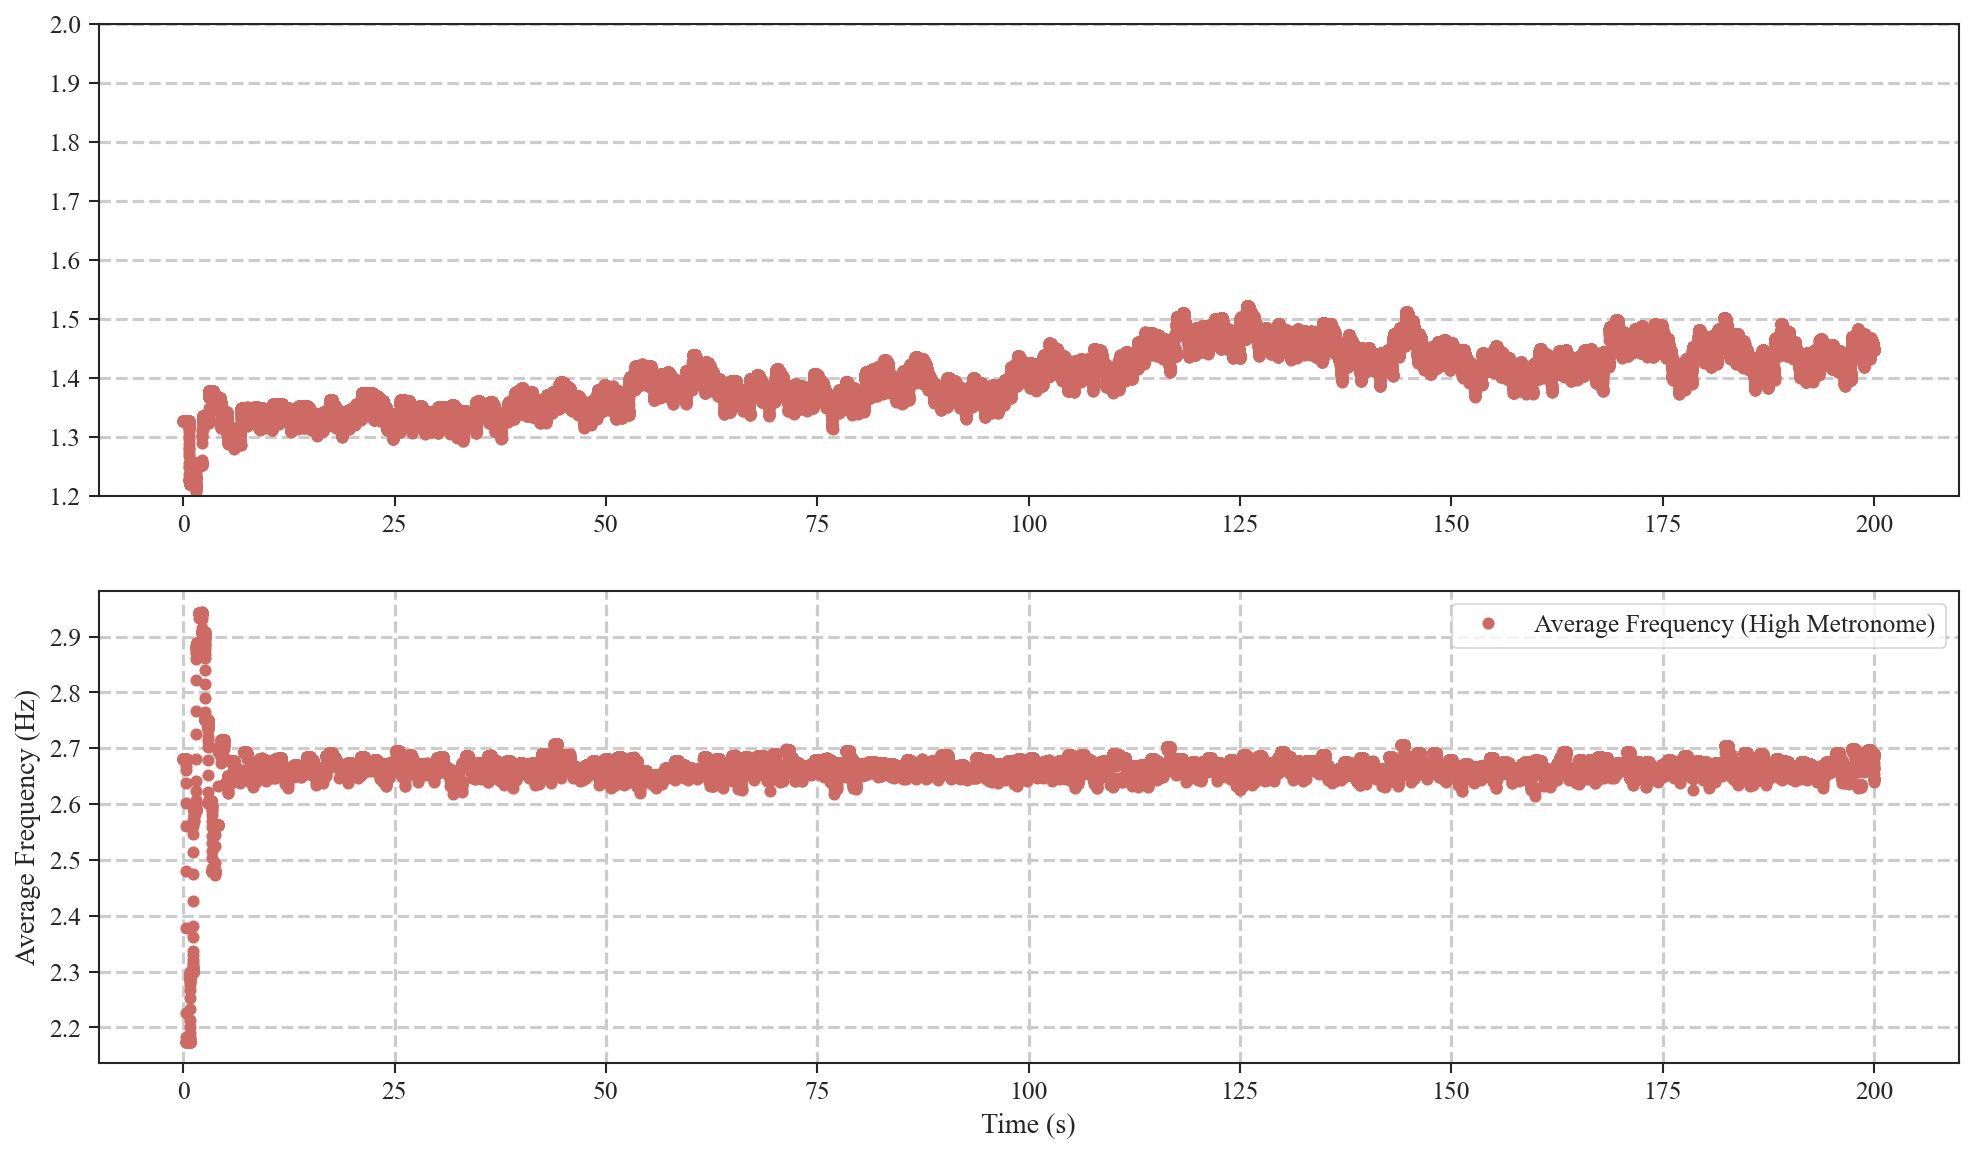

In [10]:
N = 100
w_init = np.random.normal(1.33, 0.1, N)

w_init_high = np.random.normal(2.667, 0.1, N)

x_init = np.zeros(N)
t_clap_init = np.zeros(N)

dt = 0.0025
tmax = 200


w_save, t_save, x0_save, avg_save = sim_with_metronome(x_init, 
                                                       w_init, 
                                                       t_clap_init, 
                                                       dt, 
                                                       tmax, freq_met = 1.33, 
                                                       sig=0.1, 
                                                       eps=0.1, 
                                                       met_eps = 10)


w_save_high, t_save_high, x0_save_high, avg_save_high = sim_with_metronome(x_init, 
                                                                           w_init_high, 
                                                                           t_clap_init, 
                                                                           dt, 
                                                                           tmax, 
                                                                           freq_met = 2.667, 
                                                                           sig=0.1, 
                                                                           eps=0.1, 
                                                                           met_eps = 10)

# plotting
x1 = np.linspace(0, tmax, len(avg_save))
x1_high = np.linspace(0, tmax, len(avg_save_high))

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(x1, avg_save, 'o', label='Average Frequency')
ax[0].set_ylim(1.2,2)

ax[1].plot(x1_high, avg_save_high, 'o', label='Average Frequency (High Metronome)')

plt.xlabel('Time (s)')
plt.ylabel('Average Frequency (Hz)')
#
plt.legend()
plt.grid(True)
plt.show()

In [6]:
def sim_sig_metronome(x_init, w_init, t_clap_init, dt, tmax, threshold_l, threshold_h, bpm_l, bpm_h, sig=0.1, eps=0.1, met_eps = 0.1):

    t = 0.1
    x = x_init.copy()
    w = w_init.copy()
    t_clap = t_clap_init.copy()
    x0_save = []
    
    N = len(w)
    w_save = [[] for i in range(N)]
    t_save = [[] for i in range(N)]
    avg_save = []
    
    #initialize metronome
    x_met = 0  #metronome starts at 0
    n_beat = 0  
    p = p_func(n_beat, threshold_l, threshold_h)
    interval = interval_calc(bpm_l, bpm_h, p)
    freq_met = 1 / interval

    for entry in range(len(w_save)):
        w_save[entry].append(w[entry])
        t_save[entry].append(t)

    while t < tmax:

        x_met += dt * freq_met

        if x_met >= 1:
            x_met = 0  
            n_beat += 1  

            p = p_func(n_beat, threshold_l, threshold_h)

            interval = interval_calc(bpm_l, bpm_h, p)
            freq_met = 1 / interval

            for i in range(len(x)):
                x[i] = met_update_x(x[i], met_eps, N)

        if x_met >= 1:
            x_met = 0  # reset metronome

            # affect clappers
            for i in range(len(x)):
                x[i] = met_update_x(x[i], met_eps, N)

        x = x + w * dt

        index = np.where(x >= 1)[0] 
        
        if len(index) > 0: 
            for i in index:
                x[i] = 0  
                w[i] = np.random.normal(0, sig) + 1 / (t - t_clap[i]) 
                t_clap[i] = t
                
                w_save[i].append(w[i])
                t_save[i].append(t_clap[i])

                for j in range(len(x)):
                    if j != i:
                        x[j] = update_x(x[j], eps, N) 
                    else:
                        continue             

        t += dt
        x0_save.append(x[0])

        if int(t % (dt * 10)) == 0: 
            avg_save.append(np.mean(w))
            
    return w_save, t_save, x0_save, avg_save

In [19]:
w_sig_init = np.random.normal(1.33, 0.3, N)

tmax = 32 
threshold_l = 24
threshold_h = 40
bpm_l = 80
bpm_h = 160


w_sig_save, t_sig_save, x0_sig_save, avg_sig_save = sim_sig_metronome(x_init, w_init, t_clap_init, dt, tmax, threshold_l, threshold_h, bpm_l, bpm_h, sig=0.1, eps=0.1, met_eps = 10)

1

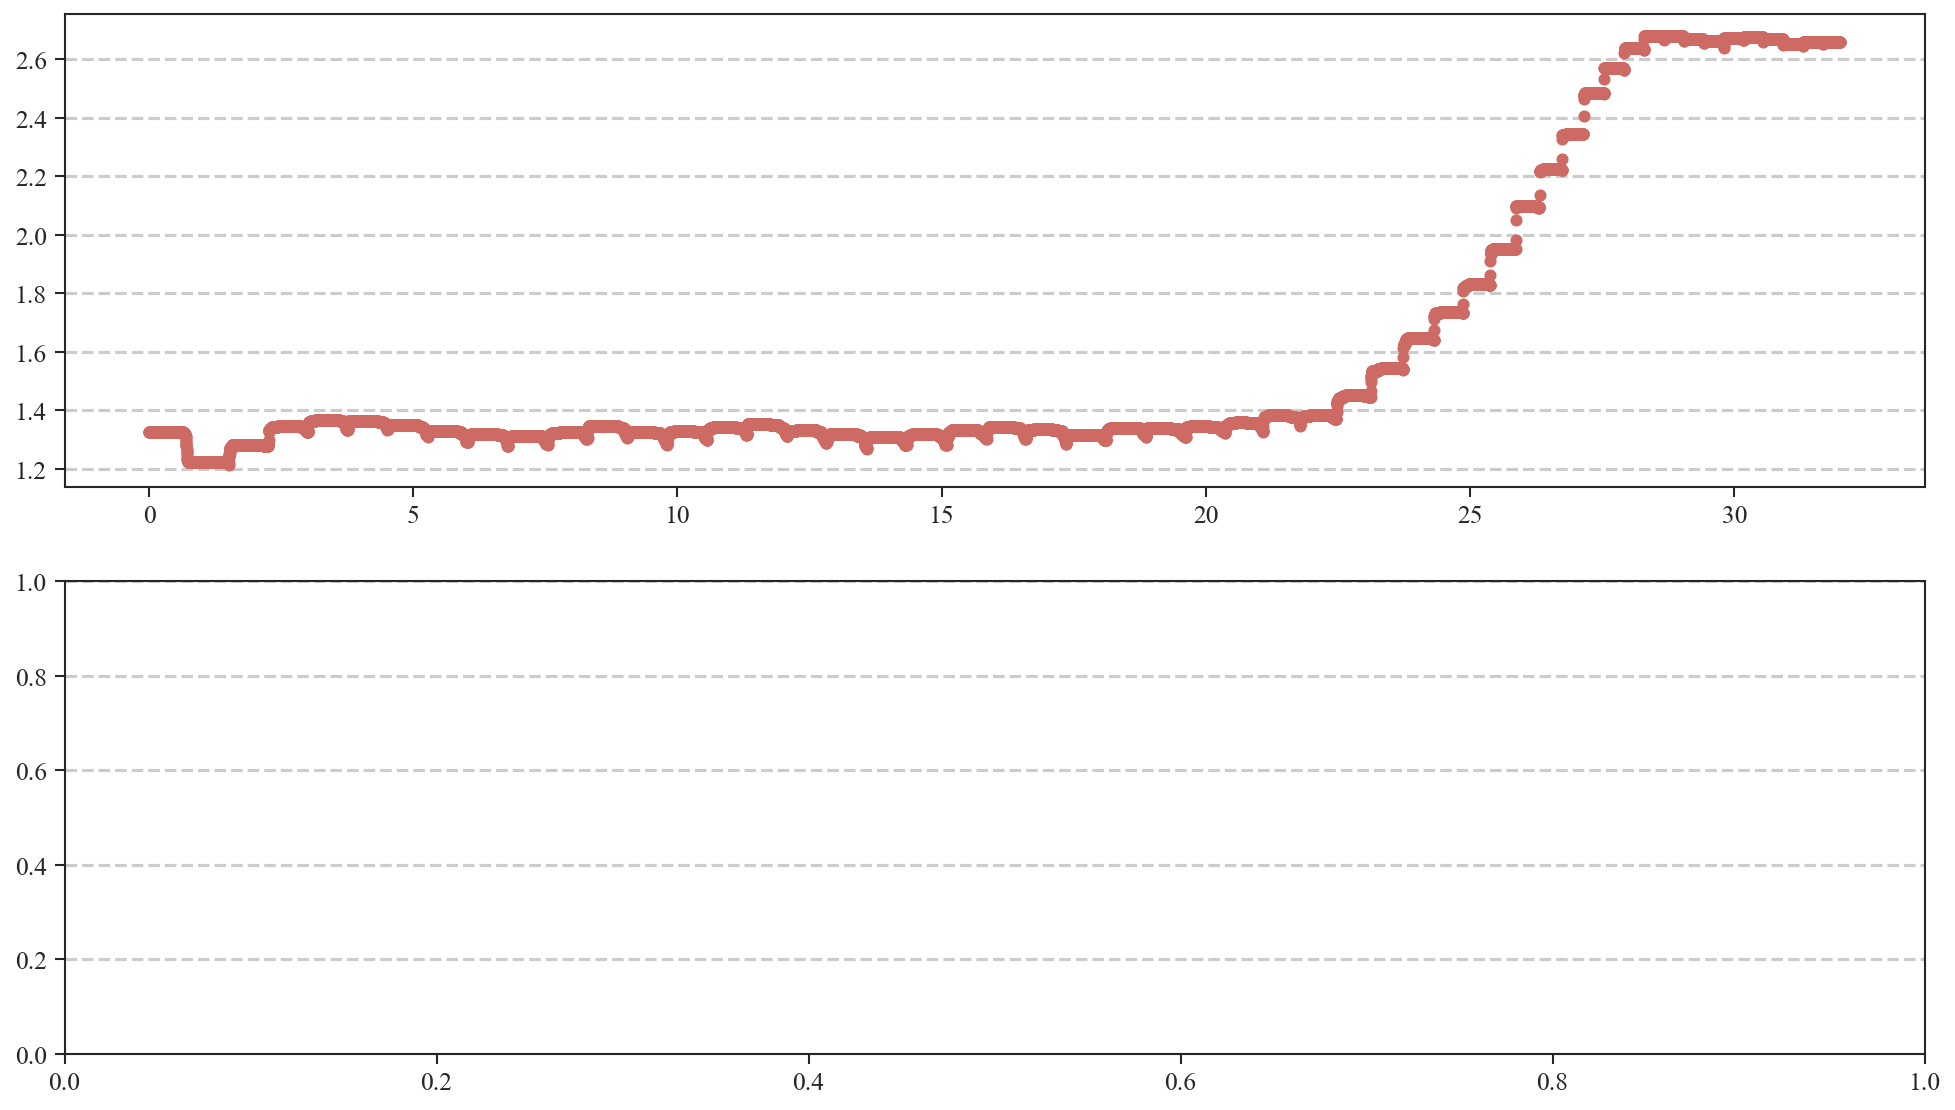

In [21]:
x1_sig = np.linspace(0, tmax, len(avg_sig_save))

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(x1_sig, avg_sig_save, 'o', label='Average Frequency')

1
#ax[1].plot(x1_high, avg_save_high, 'o', label='Average Frequency (High Metronome)')
